In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
sns.set(rc={'figure.figsize':(9, 6)})

In [2]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [3]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


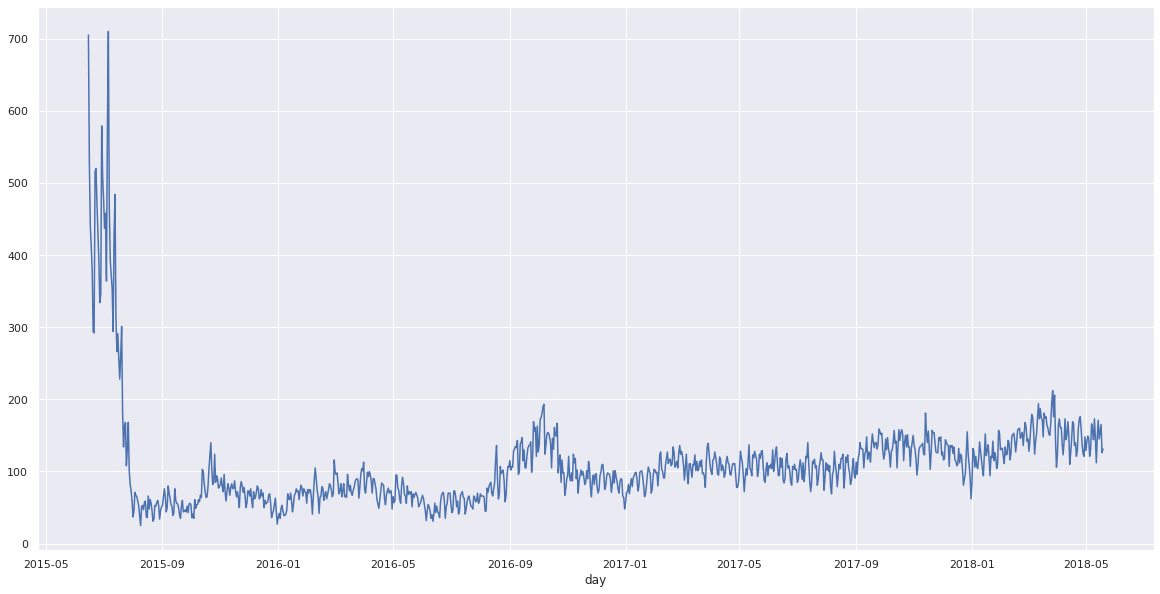

In [7]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))

In [8]:
users_events_data = events_data.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0).reset_index()

In [9]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


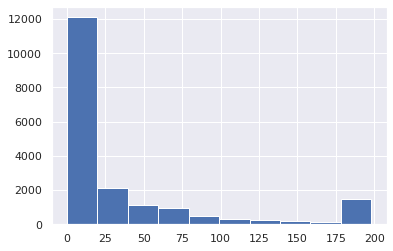

In [10]:
users_events_data.discovered.hist()

In [11]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [12]:
users_scores = submissions_data.pivot_table(index='user_id', 
                                            columns='submission_status', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0).reset_index()

In [13]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [14]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
                        .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [15]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)

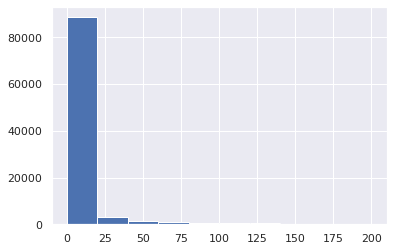

In [16]:
gap_data[gap_data < 200].hist()

In [17]:
gap_data.quantile(0.95)

59.760440972222156

In [18]:
treshold = 30 * 24 * 60 * 60

In [19]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}) \
                        .rename(columns={'timestamp': 'last_timestamp'})

In [20]:
users_data['is_gone_user'] = (events_data['timestamp'].max() - users_data.last_timestamp) > treshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [21]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [22]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer').fillna(0)

In [23]:
days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [24]:
users_data = users_data.merge(days, on='user_id', how='outer')

In [25]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [26]:
user_min_time = events_data.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)

In [27]:
users_data = users_data.merge(user_min_time, how='outer')

In [28]:
learning_time_treshold = 3 * 24 * 60 * 60

In [29]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [30]:
user_events = events_data.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='outer')
events_data_train = user_events[user_events.timestamp <= (user_events.min_timestamp + learning_time_treshold)]

In [31]:
submission_min_time = submissions_data.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)
user_submissions = submissions_data.merge(submission_min_time[['user_id', 'min_timestamp']], on='user_id', how='outer')
submissions_data_train = user_submissions[user_submissions.timestamp <= (user_submissions.min_timestamp + learning_time_treshold)]

In [32]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434346056
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434346056
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434346056
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434346056
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434346056


In [33]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()

In [34]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame() \
        .reset_index().rename(columns={'step_id': 'steps_tried'})

In [35]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [36]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                   columns='submission_status', 
                                   values='step_id', 
                                   aggfunc='count', 
                                   fill_value=0).reset_index())

In [37]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.0
1,3,1,4,4,4,0.5
2,5,1,2,2,2,0.5
3,8,1,11,9,21,0.3
4,14,1,1,0,1,0.0


In [38]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                          columns='action',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [39]:
X = X.fillna(0)

In [40]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [41]:
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True
2,5,1.0,2.0,2.0,2.0,0.5,1,False,True
3,8,1.0,11.0,9.0,21.0,0.3,154,False,True
4,14,1.0,1.0,0.0,1.0,0.0,9,False,True


In [42]:
X = X[(X.is_gone_user) | (X.passed_course)]

In [43]:
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.0,9,False,True
1,3,1.0,4.0,4.0,4.0,0.5,20,False,True
2,5,1.0,2.0,2.0,2.0,0.5,1,False,True
3,8,1.0,11.0,9.0,21.0,0.3,154,False,True
4,14,1.0,1.0,0.0,1.0,0.0,9,False,True


In [44]:
y = X.passed_course.map(int)

In [45]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [46]:
X = X.set_index('user_id')

In [47]:
X.head()

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.0,9
3,1.0,4.0,4.0,4.0,0.5,20
5,1.0,2.0,2.0,2.0,0.5,1
8,1.0,11.0,9.0,21.0,0.3,154
14,1.0,1.0,0.0,1.0,0.0,9


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [50]:
clf = RandomForestClassifier()

In [51]:
parametrs = {'n_estimators':range(1, 51), 'max_depth':range(1, 51)}

In [52]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [53]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [54]:
grid_search_cv_clf.best_params_

{'max_depth': 4, 'n_estimators': 5}

In [55]:
best_clf = grid_search_cv_clf.best_estimator_

In [56]:
best_clf.score(X_test, y_test)

0.9273921832884097

In [57]:
feature_importances = best_clf.feature_importances_

In [58]:
feature_importances_df = pd.DataFrame({'feature':list(X_train),
                                       'feature_importances':feature_importances})

In [59]:
feature_importances_df

,feature,feature_importances
0,day,0.285682
1,steps_tried,0.417363
2,correct,0.184551
3,wrong,0.010242
4,correct_ratio,0.074412
5,viewed,0.027751


In [60]:
feature_importances_df.sort_values('feature_importances', ascending=False)

,feature,feature_importances
1,steps_tried,0.417363
0,day,0.285682
2,correct,0.184551
4,correct_ratio,0.074412
5,viewed,0.027751
3,wrong,0.010242
